In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

### **Libraries**

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
import random
warnings.simplefilter('ignore')
import catboost as cat
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss, plot_confusion_matrix, plot_roc_curve,auc, accuracy_score, mean_squared_error


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('Test.csv')
VD = pd.read_csv('VariableDefinitions.csv')
result = pd.read_csv('sample_submission.csv')

In [ ]:
VD

,Variable Definitions,Unnamed: 1,Unnamed: 2
0,NaN,French,English
1,NaN,Le dataset churn comprend 19 variables dont 15...,The churn dataset includes 19 variables includ...
2,user_id,NaN,NaN
3,REGION,la localité de chaque client,the location of each client
4,TENURE,la durée dans le reseau,duration in the network
5,MONTANT,montant de recharge,top-up amount
6,FREQUENCE_RECH,nombre de fois que le client a fait une recharge,number of times the customer refilled
7,REVENUE,revenu mensuel de chaque client,monthly income of each client
8,ARPU_SEGMENT,revenu sur 90 jours/3,income over 90 days / 3
9,FREQUENCE,nombre de fois que client à fait un revenu,number of times the client has made an income


### **Feature engineering**

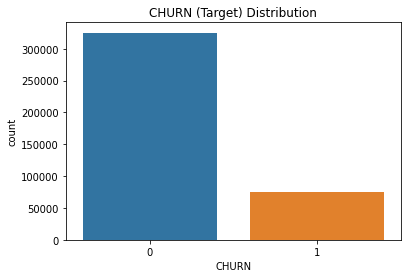

In [ ]:
sns.countplot(train.CHURN)
plt.title('CHURN (Target) Distribution');

In [ ]:
train.isnull().sum()

user_id                0
REGION            157520
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
ZONE1             368310
ZONE2             374487
MRG                    0
REGULARITY             0
TOP_PACK          167329
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

To check the correlation between the features and the target variable

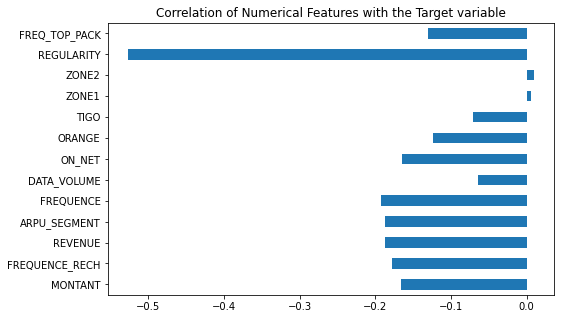

In [ ]:
train.corr('spearman')['CHURN'][:-1].plot.barh(figsize=(8,5), 
                                          title='Correlation of Numerical Features with the Target variable');

Checking for outliers

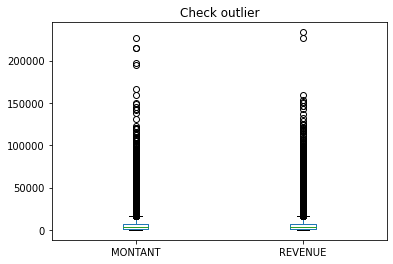

In [ ]:
train[['MONTANT', 'REVENUE']].plot.box(title= 'Check outlier')
plt.show()


FIlling Missing values

In [ ]:
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

In [ ]:
train['is_train'] = 1
test['is_train'] = 0
all_data = pd.concat([train, test])
all_data.tail(3)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,is_train
99997,a2f84faffbc995bd0e2d726fa4ffdb93f11646ed,-999,I 18-21 month,1800.0,7.0,1799.0,600.0,9.0,81.0,2.0,0.0,-999.0,-999.0,-999.0,NO,60,"Data:200F=Unlimited,24H",5.0,NaN,0
99998,afa76e894df4201fc77eb714de7d1f262299611a,THIES,K > 24 month,2500.0,4.0,2515.0,838.0,4.0,-999.0,43.0,106.0,4.0,-999.0,-999.0,NO,16,All-net 500F=2000F;5d,5.0,NaN,0
99999,c08a2d84b87c1f5d4bb318114f508b77aa8e2663,MATAM,K > 24 month,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NO,7,-999,-999.0,NaN,0


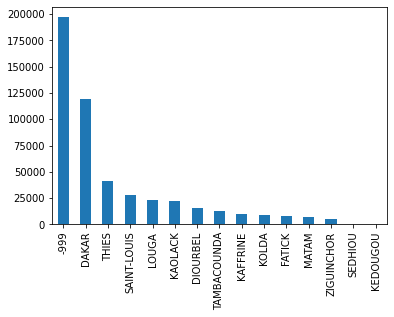

In [ ]:
all_data['REGION'].value_counts().plot.bar()

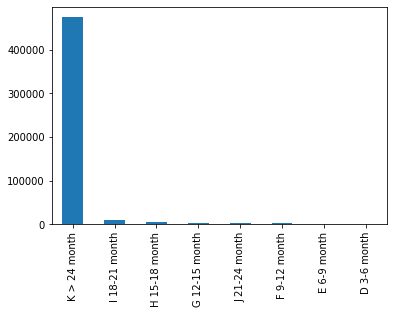

In [ ]:
all_data['TENURE'].value_counts().plot.bar()
plt.show()

Encoding the Categorical Variables

In [ ]:
#add dummies encoding for the features TENURE and REGION
all_data = pd.concat([all_data, pd.get_dummies(all_data['TENURE'], prefix= 'TENURE', drop_first= True)], axis= 1)
all_data = pd.concat([all_data, pd.get_dummies(all_data['REGION'], prefix= 'REGION', drop_first= True)], axis= 1)

In [ ]:
#add one hot encoding => REGION and count encoding for other categorical features
all_data['REGION'] = all_data['REGION'].factorize()[0]
all_data['TENURE'] = all_data['TENURE'].map(all_data['TENURE'].value_counts())
all_data['TOP_PACK'] = all_data['TOP_PACK'].map(all_data['TOP_PACK'].value_counts())
all_data['MRG'] = all_data['MRG'].map(all_data['MRG'].value_counts())

In [ ]:
all_data['TF'] = all_data['REGULARITY'] * all_data['FREQUENCE']
all_data['MR'] = all_data['MONTANT'] - all_data['REVENUE']

In [ ]:
all_train = all_data.loc[all_data['is_train']==1]
all_test = all_data.loc[all_data['is_train']==0]

In [ ]:
all_train = all_data.loc[all_data['is_train']==1]
all_test = all_data.loc[all_data['is_train']==0]


In [ ]:
features = [c for c in all_train.columns if c not in ['CHURN', 'user_id', 'is_train']]

## Model

In [ ]:
SEED = 0

random.seed(SEED)
np.random.seed(SEED)

err = list()
    
preds_df = pd.DataFrame()
preds_df['user_id'] = all_test['user_id']
preds_df['CHURN'] = np.zeros(len(all_test))

fold = StratifiedKFold(n_splits= 3, shuffle= True, random_state= 0)

i = 1

#Standardize
scaler = StandardScaler()

for train_index, test_index in fold.split(all_train[features], all_train['CHURN']):

    print('fold n°: ', i)

    x_data, x_val = all_train[features].iloc[train_index], all_train[features].iloc[test_index]

    y_data, y_val = all_train['CHURN'].iloc[train_index], all_train['CHURN'].iloc[test_index]
        
    #x_data, y_data = smote.fit_sample(x_data, y_data)
    
    scaler.fit(x_data)
    
    x_data = scaler.transform(x_data)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(all_test[features])


    
    model = CatBoostClassifier(learning_rate= 0.10001, random_state= 0, num_trees= 500, max_depth= 5)
    
    model.fit(x_data, y_data, eval_set= [(x_val, y_val)], early_stopping_rounds= 300, verbose= 100)
        
    y_train_pred = model.predict_proba(x_data)

    y_test_pred = model.predict_proba(x_val)
        
    print('log_loss train', log_loss(y_data, y_train_pred))
    print('log_loss test', log_loss(y_val, y_test_pred))
    
    err.append(log_loss(y_val, y_test_pred))
    
    current_pred = model.predict_proba(x_test)[:,1]
        
    preds_df['CHURN'] += current_pred / fold.n_splits
        
    i = i + 1
        
print('Mean Log_loss test: ', np.mean(err))  

preds_df.head()

fold n°:  1
0:	learn: 0.5568931	test: 0.5564343	best: 0.5564343 (0)	total: 123ms	remaining: 1m 1s
100:	learn: 0.2516897	test: 0.2531981	best: 0.2531981 (100)	total: 11.7s	remaining: 46.1s
200:	learn: 0.2501109	test: 0.2526583	best: 0.2526583 (200)	total: 22.2s	remaining: 33s
300:	learn: 0.2488349	test: 0.2525323	best: 0.2525310 (298)	total: 32.5s	remaining: 21.5s
400:	learn: 0.2476748	test: 0.2525529	best: 0.2525292 (309)	total: 42.8s	remaining: 10.6s
499:	learn: 0.2467569	test: 0.2525898	best: 0.2525292 (309)	total: 53s	remaining: 0us

bestTest = 0.2525292286
bestIteration = 309

Shrink model to first 310 iterations.
log_loss train 0.24871035093202232
log_loss test 0.25252922860049515
fold n°:  2
0:	learn: 0.5562680	test: 0.5565481	best: 0.5565481 (0)	total: 99ms	remaining: 49.4s
100:	learn: 0.2520650	test: 0.2528459	best: 0.2528459 (100)	total: 10.4s	remaining: 41.3s
200:	learn: 0.2504153	test: 0.2520969	best: 0.2520969 (200)	total: 20.9s	remaining: 31.1s
300:	learn: 0.2491846	test: 

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.782949
1,5335efd940280b82143272275637d1e65d37eadb,0.657167
2,a581f4fa08677c26f83f643248c667e241043086,0.142639
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0.000795
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0.000180


In [ ]:
preds_df